## 分布式训练原理

而在深度学习中，模型的训练与计算过程则没有太多的分支，基本上都是矩阵或者向量的计算，而这种暴力又单纯的计算形式非常适合用 GPU 处理，GPU 的整个处理过程就是一个流式处理的过程。

于是就有了多个 GPU 协同工作的办法

谁分布了？答案有两个：数据与模型。

怎么分布？答案也有两个：单机多卡与多机多卡。

### 单机单卡



In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data = torch.ones((3, 3))
print(data.device)
# Get: cpu

# 获得device
device = torch.device("cuda:0")

# 将data推到gpu上
data_gpu = data.to(device)
print(data_gpu.device)
# Get: cuda:0


cpu
cuda:0


我们首先创建了一个常规的张量 data，通过 device 属性，可以看到 data 现在是在 CPU 上的。

随后，我们通过 to() 函数将 data 迁移到 GPU 上，同样也能通过 device 属性看到 data 确实已经存在于 GPU 上了。

对于模型也可以

```python
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = nn.Sequential(nn.Linear(3, 3))
net.to(device)
```


### 单机多卡

```python

import torch
torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
```
dim 表示在哪个维度上进行数据并行，默认是第 0 维，也就是 batch 维度
module 就是你定义的模型，device_ids 即为训练模型时用到的 GPU 设备号，output_device 表示输出结果的 device，默认为 0 也就是第一块卡

In [7]:

import os
import torch
import torch.nn as nn

class ASimpleNet(nn.Module):
    def __init__(self, layers=3):
        super(ASimpleNet, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(3, 3, bias=False) for i in range(layers)])

    def forward(self, x):
        print("forward batchsize is: {}".format(x.size()[0]))
        for layer in self.linears:   
            x = layer(x)
            x = torch.relu(x)
        return x

        
batch_size = 16
inputs = torch.randn(batch_size, 3)
labels = torch.randn(batch_size, 3)
inputs, labels = inputs.to(device), labels.to(device)
net = ASimpleNet()
net = nn.DataParallel(net)
net.to(device)
print("CUDA_VISIBLE_DEVICES :", os.environ.get("CUDA_VISIBLE_DEVICES", "Not Set"))


for epoch in range(1):
    outputs = net(inputs)

# Get:
# CUDA_VISIBLE_DEVICES : 3, 2, 1, 0
# CUDA_VISIBLE_DEVICES : Not Set means using all available GPUs
# forward batchsize is: 4
# forward batchsize is: 4
# forward batchsize is: 4
# forward batchsize is: 4


CUDA_VISIBLE_DEVICES : Not Set
forward batchsize is: 4
forward batchsize is: 4
forward batchsize is: 4
forward batchsize is: 4


/home/uceeqz4/.conda/envs/pytorch311/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


In [8]:
print("GPU count:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i} -> {torch.cuda.get_device_name(i)}")

GPU count: 4
GPU 0 -> NVIDIA H100 NVL
GPU 1 -> NVIDIA H100 NVL
GPU 2 -> NVIDIA H100 NVL
GPU 3 -> NVIDIA H100 NVL


In [9]:
# 给一个测试
from PIL import Image
import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.RandomResizedCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data


![image15.png](mdfiles/image15.png)

主要如果要对模型进行微调也需要在DataParallel之前进行模型的微调，否则会报错


In [22]:
import torchvision.models as models
import torch
from torch.utils.data import DataLoader
os.environ['TORCH_HOME'] = './data'

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

alexnet = models.alexnet(pretrained=False)

state_dict = torch.load('./data/hub/checkpoints/alexnet-owt-7be5be79.pth', map_location='cpu')
alexnet.load_state_dict(state_dict)

# 修改模型（微调）
fc_in_features = alexnet.classifier[6].in_features # 修改预训练模型的输出分类数
alexnet.classifier[6] = torch.nn.Linear(fc_in_features, 10).to(device)
print(alexnet)

# 推到GPU
alexnet = alexnet.to(device)

# 多卡
alexnet = nn.DataParallel(alexnet, device_ids=[2,3], output_device=2)

# check the prepare multi-GPU model
print(f"Using {torch.cuda.device_count()} GPU(s)")

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                             train=True,
                                             transform=transform,
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                            train=False,
                                            transform=transform,
                                            download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.parameters(), lr=1e-4, weight_decay=1e-2, momentum=0.9)

Using device: cuda:2


/tmp/ipykernel_1541754/2177122082.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./data/hub/checkpoints/alexnet-owt-7be5be79.pth', map_locatio

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
# Train
num_epochs = 10
alexnet.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = alexnet(inputs)
        loss = criterion(outputs, targets)

        # 反向传播与优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 1.1728
Epoch [2/10], Loss: 0.9558
Epoch [3/10], Loss: 0.8886
Epoch [4/10], Loss: 0.8451
Epoch [5/10], Loss: 0.8198
Epoch [6/10], Loss: 0.7972
Epoch [7/10], Loss: 0.7847
Epoch [8/10], Loss: 0.7731
Epoch [9/10], Loss: 0.7609
Epoch [10/10], Loss: 0.7500


In [24]:
alexnet.eval()  # 切换到评估模式（禁用dropout/bn更新）
correct = 0
total = 0
with torch.no_grad():  # 测试时不需要计算梯度
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = alexnet(inputs)
        _, predicted = torch.max(outputs.data, 1)  # 取最大值对应的类别
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

accuracy = 100 * correct / total
print(f"测试准确率: {accuracy:.2f}%")

测试准确率: 75.28%


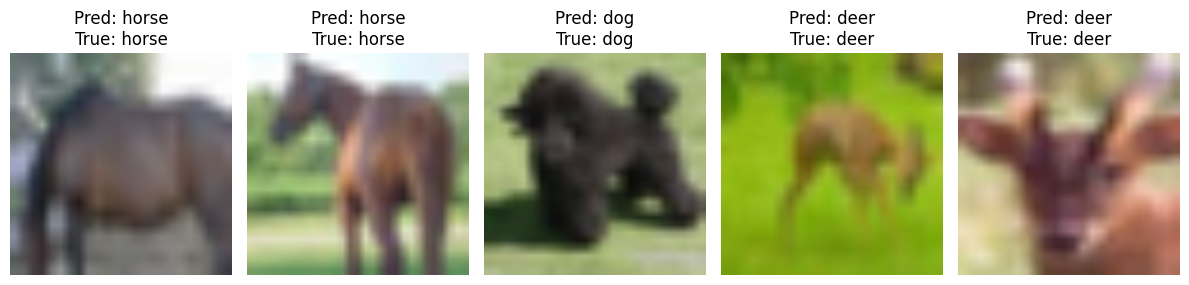

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import random

# CIFAR-10 类别名
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# 随机抽查 3 个样本
samples = 5
alexnet.eval()
with torch.no_grad():
    # 从 test_dataset 随机取3张图
    indices = random.sample(range(len(test_dataset)), samples)
    fig, axs = plt.subplots(1, samples, figsize=(12, 4))

    for i, idx in enumerate(indices):
        img, label = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)  # 加上 batch 维度
        output = alexnet(input_tensor)
        _, pred = torch.max(output, 1)

        # 反归一化：从标准化后的张量恢复到原图
        img_np = img.cpu().numpy().transpose(1, 2, 0)
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)

        axs[i].imshow(img_np)
        axs[i].set_title(f"Pred: {classes[pred.item()]}\nTrue: {classes[label]}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

### 多机多卡

多机多卡一般都是基于集群的方式进行大规模的训练，需要涉及非常多的方面，咱们这节课只讨论最基本的原理和方法。在具体实践中，你可能还会遇到其它网络或环境等问题，届时需要具体问题具体解决


DP 与 DDP刚才我们已经提到，对于单机多卡训练，有一个最简单的办法：DataParallel。

其实 PyTorch 的数据并行还有一个主要的 API，那就是 DistributedDataParallel。而 DistributedDataParallel 也是我们实现多机多卡的关键 API。

再说说 DDP，DDP 多进程控制多 GPU。系统会为每个 GPU 创建一个进程，不再有主 GPU，每个 GPU 执行相同的任务。

DDP 使用分布式数据采样器（DistributedSampler）加载数据，确保数据在各个进程之间没有重叠

在反向传播时，各 GPU 梯度计算完成后，各进程以广播的方式将梯度进行汇总平均，然后每个进程在各自的 GPU 上进行梯度更新，从而确保每个 GPU 上的模型参数始终保持一致。

由于无需在不同 GPU 之间复制模型，DDP 的传输数据量更少，因此速度更快。

* DistributedDataParallel 主要是为多机多卡而设计的，不过单机上也同样可以使用。想要弄明白 DDP 的训练机制，我们先要弄明白这几个分布式中的概念：

* group：即进程组。默认情况下，只有一个组，即一个 world。

* world_size ：表示全局进程个数。

* rank：表示进程序号，用于进程间通讯，表示进程优先级。

* rank=0 的主机为主节点。

```python

torch.distributed.init_process_group(
    backend=None, init_method=None, timeout=..., world_size=-1, rank=-1, store=None
)

```

backend：是通信所用的后端，可以是“nccl”或“gloo”。
* nccl 用于 GPU 分布式训练
* gloo 用于 CPU 进行分布式训练。

init_method：字符串类型，是一个 url，用于指定进程初始化方式，默认是 “env://”，表示从环境变量初始化，还可以使用 TCP 的方式或共享文件系统。
timeout：超时时间，默认是 30 分钟。
world_size：执行训练的所有的进程数，表示一共有多少个节点（机器）。
rank：当前进程的编号，范围是 0 到 world_size-1。
store：用于进程间通信的存储对象，默认是 None。


#### 使用 nccl 后端的代码如下

初始化

```python

torch.distributed.init_process_group(backend="nccl")

```

完成初始化以后，第二步就是模型并行化

```python

torch.nn.parallel.DistributedDataParallel(module, device_ids=None, output_device=None, dim=0)

```

dim 表示在哪个维度上进行数据并行，默认是第 0 维，也就是 batch 维度

module 就是你定义的模型，device_ids 即为训练模型时用到的 GPU 设备号

output_device 表示输出结果的 

device，默认为 0 也就是

具体调用让模型并行化的代码如下：
```python

net = torch.nn.parallel.DistributedDataParallel(net)

```

最后就是创建分布式数据采样器。在多机多卡情况下，分布式训练数据的读取也是一个问题，不同的卡读取到的数据应该是不同的。

DP 是直接将一个 batch 的数据划分到不同的卡，但是多机多卡之间进行频繁的数据传输会严重影响效率，这时就要用到分布式数据采样器 DistributedSampler，它会为每个子进程划分出一部分数据集，

从而使 DataLoader 只会加载特定的一个子数据集，以避免不同进程之间有数据重复。

```python
import torch
from torch.utils.data import DataLoader
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
data_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)

```

我们将 train_dataset 送到了 DistributedSampler 中，并创建了一个分布式数据采样器 train_sampler。
然后在构造 DataLoader 的时候,  参数中传入了一个 sampler=train_sampler，即可让不同的进程节点加载属于自己的那份子数据集

使用 DDP 时，不再是从主 GPU 分发数据到其他 GPU 上，而是各 GPU 从自己的硬盘上读取属于自己的那份数据



多机多卡一般都是基于集群的方式进行大规模的训练，需要涉及非常多的方面，咱们这节课只讨论最基本的原理和方法。在具体实践中，你可能还会遇到其它网络或环境等问题，届时需要具体问题具体解决


DP 与 DDP刚才我们已经提到，对于单机多卡训练，有一个最简单的办法：DataParallel。

其实 PyTorch 的数据并行还有一个主要的 API，那就是 DistributedDataParallel。而 DistributedDataParallel 也是我们实现多机多卡的关键 API。

再说说 DDP，DDP 多进程控制多 GPU。系统会为每个 GPU 创建一个进程，不再有主 GPU，每个 GPU 执行相同的任务。

DDP 使用分布式数据采样器（DistributedSampler）加载数据，确保数据在各个进程之间没有重叠

在反向传播时，各 GPU 梯度计算完成后，各进程以广播的方式将梯度进行汇总平均，然后每个进程在各自的 GPU 上进行梯度更新，从而确保每个 GPU 上的模型参数始终保持一致。

由于无需在不同 GPU 之间复制模型，DDP 的传输数据量更少，因此速度更快。

* DistributedDataParallel 主要是为多机多卡而设计的，不过单机上也同样可以使用。想要弄明白 DDP 的训练机制，我们先要弄明白这几个分布式中的概念：

* group：即进程组。默认情况下，只有一个组，即一个 world。

* world_size ：表示全局进程个数。

* rank：表示进程序号，用于进程间通讯，表示进程优先级。

* rank=0 的主机为主节点。


### 多机多卡


```python
torch.distributed.init_process_group(
    backend=None, init_method=None, timeout=10, world_size=-1, rank=-1, store=None
)
```

backend：是通信所用的后端，可以是“nccl”或“gloo”。
* nccl 用于 GPU 分布式训练
* gloo 用于 CPU 进行分布式训练。

init_method：字符串类型，是一个 url，用于指定进程初始化方式，默认是 “env://”，表示从环境变量初始化，还可以使用 TCP 的方式或共享文件系统。
timeout：超时时间，默认是 30 分钟。
world_size：执行训练的所有的进程数，表示一共有多少个节点（机器）。
rank：当前进程的编号，范围是 0 到 world_size-1。
store：用于进程间通信的存储对象，默认是 None。


#### 使用 nccl 后端的代码如下

初始化

```python

torch.distributed.init_process_group(backend="nccl")

```

完成初始化以后，第二步就是模型并行化

```python

torch.nn.parallel.DistributedDataParallel(module, device_ids=None, output_device=None, dim=0)

```

dim 表示在哪个维度上进行数据并行，默认是第 0 维，也就是 batch 维度

module 就是你定义的模型，device_ids 即为训练模型时用到的 GPU 设备号

output_device 表示输出结果的 

device，默认为 0 也就是

具体调用让模型并行化的代码如下：
```python

net = torch.nn.parallel.DistributedDataParallel(net)

```

最后就是创建分布式数据采样器。在多机多卡情况下，分布式训练数据的读取也是一个问题，不同的卡读取到的数据应该是不同的。

DP 是直接将一个 batch 的数据划分到不同的卡，但是多机多卡之间进行频繁的数据传输会严重影响效率，这时就要用到分布式数据采样器 DistributedSampler，它会为每个子进程划分出一部分数据集，

从而使 DataLoader 只会加载特定的一个子数据集，以避免不同进程之间有数据重复。

```python
import torch
from torch.utils.data import DataLoader
train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
data_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
```

我们将 train_dataset 送到了 DistributedSampler 中，并创建了一个分布式数据采样器 train_sampler。
然后在构造 DataLoader 的时候,  参数中传入了一个 sampler=train_sampler，即可让不同的进程节点加载属于自己的那份子数据集

使用 DDP 时，不再是从主 GPU 分发数据到其他 GPU 上，而是各 GPU 从自己的硬盘上读取属于自己的那份数据




官方的 ImageNet 的示例，以后你可以把这个小项目当做分布式训练的一个模板来使用。

```python
if args.distributed:
     if args.dist_url == "env://" and args.rank == -1:
         args.rank = int(os.environ["RANK"])
     if args.multiprocessing_distributed:
         # For multiprocessing distributed training, rank needs to be the
         # global rank among all the processes
         args.rank = args.rank * ngpus_per_node + gpu
     dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                             world_size=args.world_size, rank=args.rank)
```

这里你可以重点关注示例代码中的“args.distributed”参数，args.distributed 为 True，表示使用 DDP，反之表示使用 DP。

我们来看 main_worker 函数中这段针对 DDP 的初始化代码，如果使用 DDP，那么使用 init_process_group 函数初始化进程组。ngpus_per_node 表示每个节点的 GPU 数量


main_worker 函数中模型并行化的代码如下：
```python
if not torch.cuda.is_available():
    print('using CPU, this will be slow')
elif args.distributed:
    # For multiprocessing distributed, DistributedDataParallel constructor
    # should always set the single device scope, otherwise,
    # DistributedDataParallel will use all available devices.
    if args.gpu is not None:
        torch.cuda.set_device(args.gpu)
        model.cuda(args.gpu)
        # When using a single GPU per process and per
        # DistributedDataParallel, we need to divide the batch size
        # ourselves based on the total number of GPUs we have
        args.batch_size = int(args.batch_size / ngpus_per_node)
        args.workers = int((args.workers + ngpus_per_node - 1) / ngpus_per_node)
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
    else:
        model.cuda()
        # DistributedDataParallel will divide and allocate batch_size to all
        # available GPUs if device_ids are not set
        model = torch.nn.parallel.DistributedDataParallel(model)
elif args.gpu is not None:
    torch.cuda.set_device(args.gpu)
    model = model.cuda(args.gpu)
else:
    # DataParallel will divide and allocate batch_size to all available GPUs
    if args.arch.startswith('alexnet') or args.arch.startswith('vgg'):
        model.features = torch.nn.DataParallel(model.features)
        model.cuda()
    else:
        model = torch.nn.DataParallel(model).cuda()
```

并行化之后就是创建分布式数据采样器

```python
if args.distributed:
    train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
else:
    train_sampler = None

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=(train_sampler is None),
    num_workers=args.workers, pin_memory=True, sampler=train_sampler
)
```

sampler 是分布式数据采样器，如果使用 DDP，那么就创建 DistributedSampler，否则 sampler 设为 None。
shuffle 参数表示是否对数据进行打乱，在建立 Dataloader 的过程中，如果 sampler 参数不为 None，那么 shuffle 参数不应该被设置。


我们需要为每个机器节点上的每个 GPU 启动一个进程
```python

 ngpus_per_node = torch.cuda.device_count()
 if args.multiprocessing_distributed:
     # Since we have ngpus_per_node processes per node, the total world_size
     # needs to be adjusted accordingly
     args.world_size = ngpus_per_node * args.world_size
     # Use torch.multiprocessing.spawn to launch distributed processes: the
     # main_worker process function
     mp.spawn(main_worker, nprocs=ngpus_per_node, args=(ngpus_per_node, args))
 else:
     # Simply call main_worker function
     main_worker(args.gpu, ngpus_per_node, args)
```
ngpus_per_node 是每个节点的 GPU 数量（每个节点 GPU 数量相同），如果是多进程，ngpus_per_node * args.world_size 则表示所有的节点中一共有多少个 GPU，即总进程数

一般情况下，进程 0 是主进程，比如我们会在主进程中保存模型或打印 log 信息。当节点数为 1 时，实际上就是单机多卡，所以说 DDP 既可以支持多机多卡，也可以支持单机多卡。

main_worker 调用如下

```python
main_worker(args.gpu, ngpus_per_node, args)
```

args.gpu 表示当前所使用 GPU 的 id。而通过 mp.spawn 调用之后，会为每个节点上的每个 GPU 都启动一个进程

每个进程运行 main_worker(i, ngpus_per_node, args)，其中 i 是从 0 到 ngpus_per_node-1


模型保存代码

```python
if not args.multiprocessing_distributed or (args.multiprocessing_distributed
         and args.rank % ngpus_per_node == 0):
     save_checkpoint({
         'epoch': epoch + 1,
         'arch': args.arch,
         'state_dict': model.state_dict(),
         'best_acc1': best_acc1,
         'optimizer' : optimizer.state_dict(),
     }, is_best)
```

使用 DDP 意味着使用多进程，如果直接保存模型，每个进程都会执行一次保存操作，此时只使用主进程中的一个 GPU 来保存即可。

torch.distributed.init_process_group(backend=“nccl”) 函数中，backend 参数可选哪些后端，它们分别有什么区别？

* nccl 用于 GPU 分布式训练
* gloo 用于 CPU 进行分布式训练。
* mpi 用于高性能计算集群中的分布式训练。


1. GLOO 支持绝大部分 CPU 上对于 tensor 的 communication function，但在 GPU 上只支持 broadcast 以及 all_reduced 函数；
2. NCCL 支持大部分 GPU上对于 tensor 的 communication function，但不支持 CPU；
3. PyTorch 自带 NCCL 和 GLOO，但要使用 MPI 后端则需要在安装了 MPI 的 host 上从源码构建 PyTorch；
3. MPI 支持绝大部分 CPU 和 GPU 上的函数，但对于 CUDA 的支持必须是这个 host 上构建的 PyTorch 支持 CUDA 才可以。


 PyTorch 文档：https://pytorch.org/docs/stable/distributed.html